In [1]:
import statsmodels.api as sm
import statsmodels.tsa as tsa
import scipy.stats as sts
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

1. Выбрать данные, подходящие по теме исследования. 
2. Построить спецификацию модели
3. Применить метод геометрической прогрессии.
4. Сделать преобразование Койка
5. Сделать h-тест
6. Построить модель адаптивных ожиданий
7. Сделать частичную коректировку модели
8. Лаги Алмон

**Тема: Исследование зависимости цен акции Норильского никеля от курса доллара в рублях**

# 1. Выбрать данные, подходящие по теме исследования. 

## Импорт данных

In [2]:
df = pd.read_excel('GMKN_USDRUB.xlsx', sheet_name='Sheet1')
df

,DATE,GMKN_CLOSE,USDRUB_TOM_CLOSE
0,2023-04-15,157.86,81.7900
1,2023-04-18,159.00,81.4025
2,2023-04-19,159.08,81.4500
3,2023-04-20,159.18,81.8975
4,2023-04-21,158.02,81.5550
...,...,...,...
246,2024-04-10,164.00,92.3050
247,2024-04-11,163.30,92.2400
248,2024-04-12,161.48,92.5000
249,2024-04-13,164.80,92.7000


Описание данных:\
DATE - День на закрытие торговых сессий в период с 14.04.2023 по 15.04.2024\
Y - GMKN_CLOSE - Цена акций ГМК Норникель (тикер - GMKN) на закрытие торговой сессии\
X - USDRUB_TOM_CLOSE - Стоимость одного доллара в рублях на закрытие торговой сессии

## Визуализация данных

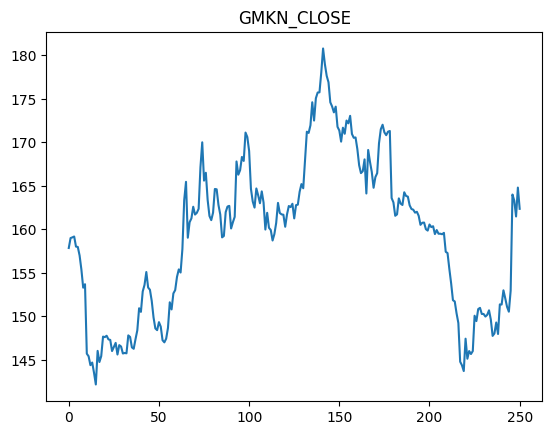

In [3]:
plt.plot(df["GMKN_CLOSE"]) #Y
plt.title("GMKN_CLOSE")
plt.show()

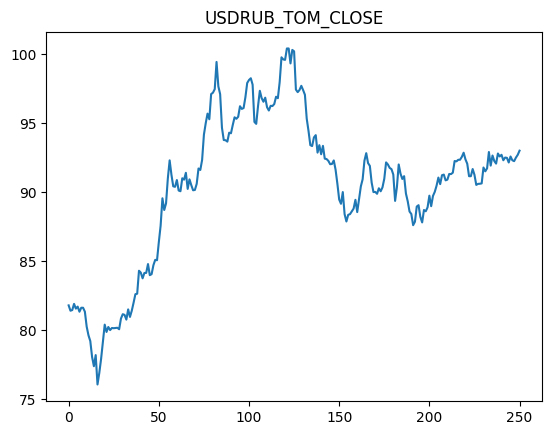

In [4]:
plt.plot(df["USDRUB_TOM_CLOSE"]) #X
plt.title("USDRUB_TOM_CLOSE")
plt.show()

По графикам видно, что котировки на некоторых участках имеют схожие тендеции

# 2. Построить спецификацию модели

## Модель с распределенными лагами

In [5]:
X_rasp = pd.DataFrame(df['USDRUB_TOM_CLOSE'])[::-1]
X_rasp.columns = ['X (t)']

In [6]:
for i in range(len(X_rasp) - 1):
    X_rasp[f'X (t - {i + 1})'] = X_rasp['X (t)'].shift(-i - 1)

In [7]:
X_rasp = X_rasp[::-1]
Y = df['GMKN_CLOSE']
X_rasp.head()

,X (t),X (t - 1),X (t - 2),X (t - 3),X (t - 4),X (t - 5),X (t - 6),X (t - 7),X (t - 8),X (t - 9),...,X (t - 241),X (t - 242),X (t - 243),X (t - 244),X (t - 245),X (t - 246),X (t - 247),X (t - 248),X (t - 249),X (t - 250)
0,81.7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.4025,81.7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,81.4500,81.4025,81.7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.8975,81.4500,81.4025,81.7900,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,81.5550,81.8975,81.4500,81.4025,81.79,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
X_rasp = sm.add_constant(X_rasp)
i = 2
model = sm.OLS(Y[i:], X_rasp.iloc[i:,:i+1], hasconst = True).fit()
print(model.summary2(title = 'Модель с распределенными лагами. 1 лаг'))

              Модель с распределенными лагами. 1 лаг
Model:              OLS              Adj. R-squared:     0.282    
Dependent Variable: GMKN_CLOSE       AIC:                1721.2062
Date:               2024-04-23 10:34 BIC:                1731.7586
No. Observations:   249              Log-Likelihood:     -857.60  
Df Model:           2                F-statistic:        49.67    
Df Residuals:       246              Prob (F-statistic): 7.60e-19 
R-squared:          0.288            Scale:              58.127   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          79.0407    8.1411   9.7088  0.0000  63.0055  95.0758
X (t)          -0.1767    0.6309  -0.2800  0.7797  -1.4193   1.0659
X (t - 1)       1.0641    0.6276   1.6955  0.0912  -0.1721   2.3003
------------------------------------------------------------------
Omn

In [9]:
t_cr = sts.t(model.df_resid).isf(0.05/2)
t_cr

1.9696541761781068

Для модели с одним лагом: R^2 = 0.288, по криетрию Стьюдента значимой является только константа

In [10]:
X_rasp = sm.add_constant(X_rasp)
i = 6
model = sm.OLS(Y[i:], X_rasp.iloc[i:,:i+1], hasconst = True).fit()
print(model.summary2(title = 'Модель с распределенными лагами. 5 лагов'))

             Модель с распределенными лагами. 5 лагов
Model:              OLS              Adj. R-squared:     0.327    
Dependent Variable: GMKN_CLOSE       AIC:                1685.7326
Date:               2024-04-23 10:34 BIC:                1710.2414
No. Observations:   245              Log-Likelihood:     -835.87  
Df Model:           6                F-statistic:        20.72    
Df Residuals:       238              Prob (F-statistic): 1.69e-19 
R-squared:          0.343            Scale:              55.396   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          72.3513    8.1792   8.8458  0.0000  56.2385  88.4641
X (t)           0.0991    0.6235   0.1590  0.8738  -1.1292   1.3275
X (t - 1)       0.1234    0.9198   0.1342  0.8934  -1.6886   1.9354
X (t - 2)      -0.2134    0.9196  -0.2321  0.8167  -2.0249   1.5981
X

In [11]:
t_cr = sts.t(model.df_resid).isf(0.05/2)
t_cr

1.9699815295289818

Для модели с пятью лагами: R^2 = 0.343, по криетрию Стьдента значимой является только константа и Y(t-5)\
R^2 стал больше по сравнению с моделью с одним лагом 

In [12]:
X_rasp = sm.add_constant(X_rasp)
i = 11
model = sm.OLS(Y[i:], X_rasp.iloc[i:,:i+1], hasconst = True).fit()
print(model.summary2(title = 'Модель с распределенными лагами. 10 лагов'))

            Модель с распределенными лагами. 10 лагов
Model:              OLS              Adj. R-squared:     0.410    
Dependent Variable: GMKN_CLOSE       AIC:                1626.3121
Date:               2024-04-23 10:34 BIC:                1668.0798
No. Observations:   240              Log-Likelihood:     -801.16  
Df Model:           11               F-statistic:        16.08    
Df Residuals:       228              Prob (F-statistic): 3.64e-23 
R-squared:          0.437            Scale:              48.897   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          65.3836    8.0097   8.1631  0.0000  49.6011  81.1661
X (t)          -0.0636    0.5977  -0.1064  0.9154  -1.2412   1.1141
X (t - 1)       0.2574    0.8792   0.2928  0.7700  -1.4751   1.9899
X (t - 2)       0.0300    0.8802   0.0341  0.9728  -1.7044   1.7644
X

In [13]:
t_cr = sts.t(model.df_resid).isf(0.05/2)
t_cr

1.9704231946733297

Для модели с десятью лагами: R^2 = 0.437, по криетрию Стьдента значимой является только константа и Y(t-10)\
R^2 стал больше по сравнению с моделью с пятью лагами 

**Вывод: при увеличении количества лагов в модели, точность модели растет, но при этом все лаговые переменные, кроме самого позднего лага, являются не значимыми. Вернусь к модели с одним лагом.**

In [14]:
X_rasp = sm.add_constant(X_rasp)
i = 2
model = sm.OLS(Y[i:], X_rasp.iloc[i:,:i+1], hasconst = True).fit()
print(model.summary2(title = 'Модель с распределенными лагами. 1 лаг'))

              Модель с распределенными лагами. 1 лаг
Model:              OLS              Adj. R-squared:     0.282    
Dependent Variable: GMKN_CLOSE       AIC:                1721.2062
Date:               2024-04-23 10:34 BIC:                1731.7586
No. Observations:   249              Log-Likelihood:     -857.60  
Df Model:           2                F-statistic:        49.67    
Df Residuals:       246              Prob (F-statistic): 7.60e-19 
R-squared:          0.288            Scale:              58.127   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          79.0407    8.1411   9.7088  0.0000  63.0055  95.0758
X (t)          -0.1767    0.6309  -0.2800  0.7797  -1.4193   1.0659
X (t - 1)       1.0641    0.6276   1.6955  0.0912  -0.1721   2.3003
------------------------------------------------------------------
Omn

In [15]:
t_cr = sts.t(model.df_resid).isf(0.05/2)
t_cr

1.9696541761781068

По критерию стьюдента удалю X (t)

In [16]:
X_rasp = sm.add_constant(X_rasp)
i = 2
model = sm.OLS(Y[i:], X_rasp.iloc[i:,:i+1].drop(columns=['X (t)']), hasconst = True).fit()
print(model.summary2(title = 'Модель с распределенными лагами. 1 лаг'))

              Модель с распределенными лагами. 1 лаг
Model:              OLS              Adj. R-squared:     0.285    
Dependent Variable: GMKN_CLOSE       AIC:                1719.2856
Date:               2024-04-23 10:34 BIC:                1726.3205
No. Observations:   249              Log-Likelihood:     -857.64  
Df Model:           1                F-statistic:        99.63    
Df Residuals:       247              Prob (F-statistic): 6.25e-20 
R-squared:          0.287            Scale:              57.910   
--------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       78.7886     8.0761   9.7558   0.0000   62.8818   94.6953
X (t - 1)    0.8902     0.0892   9.9816   0.0000    0.7145    1.0658
------------------------------------------------------------------
Omnibus:               4.116        Durbin-Watson:           0.073

In [17]:
t_cr = sts.t(model.df_resid).isf(0.05/2)
t_cr

1.9696147551824699

In [18]:
model.scale**0.5

7.609840850582763

Модель с распределенными лагами:

$Y_t = a_0 + b_1 * X_{t-1} + \varepsilon_t$

$Y_t = 78.7886 + 0.8902 * X_1 + \varepsilon_t \\
\sigma = 7.61 \\
\sigma_{a_0} = 8.0761 \\
\sigma_{b_1} = 0.0892
$

Качество модели среднее. Для поиска модели с высоким качетсвом продолжу рассмотрение динамических моделей

## Авторегрессионная модель

In [19]:
avt = pd.DataFrame(df[['GMKN_CLOSE', 'USDRUB_TOM_CLOSE']])
avt

,GMKN_CLOSE,USDRUB_TOM_CLOSE
0,157.86,81.7900
1,159.00,81.4025
2,159.08,81.4500
3,159.18,81.8975
4,158.02,81.5550
...,...,...
246,164.00,92.3050
247,163.30,92.2400
248,161.48,92.5000
249,164.80,92.7000


In [20]:
Y_tn = pd.DataFrame(df['GMKN_CLOSE'])[::-1]
Y_tn.columns = ['Y (t)']
for i in range(len(Y_tn) - 1):
    Y_tn[f'Y (t - {i + 1})'] = Y_tn['Y (t)'].shift(-i - 1)
    
Y_tn = Y_tn.iloc[:,1:][::-1]
X = pd.concat([avt['USDRUB_TOM_CLOSE'],Y_tn],axis=1)
X.head()

,USDRUB_TOM_CLOSE,Y (t - 1),Y (t - 2),Y (t - 3),Y (t - 4),Y (t - 5),Y (t - 6),Y (t - 7),Y (t - 8),Y (t - 9),...,Y (t - 241),Y (t - 242),Y (t - 243),Y (t - 244),Y (t - 245),Y (t - 246),Y (t - 247),Y (t - 248),Y (t - 249),Y (t - 250)
0,81.7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.4025,157.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,81.4500,159.00,157.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.8975,159.08,159.00,157.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,81.5550,159.18,159.08,159.00,157.86,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
X_avt = sm.add_constant(X)
i = 1
model_avt = sm.OLS(Y[i:], X_avt.iloc[i:,:i+2], hasconst = True).fit()
print(model_avt.summary2(title = 'Авторегрессионная модель. 1 лаг'))

                 Авторегрессионная модель. 1 лаг
Model:              OLS              Adj. R-squared:     0.953    
Dependent Variable: GMKN_CLOSE       AIC:                1045.0393
Date:               2024-04-23 10:34 BIC:                1055.6037
No. Observations:   250              Log-Likelihood:     -519.52  
Df Model:           2                F-statistic:        2530.    
Df Residuals:       247              Prob (F-statistic): 3.01e-165
R-squared:          0.953            Scale:              3.7824   
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
const                1.6266   2.4460  0.6650 0.5067 -3.1910 6.4442
USDRUB_TOM_CLOSE     0.0530   0.0266  1.9929 0.0474  0.0006 0.1053
Y (t - 1)            0.9598   0.0160 59.9428 0.0000  0.9283 0.9914
------------------------------------------------------------------
Omnibus:     

R^2 = 0.953\
Для нахождения модели с максимальным R^2 воспользуюсь циклом

In [22]:
maxi = 0
itog = 0
for i in range(1, 60):
    X_avt = sm.add_constant(X)
    model_avt = sm.OLS(Y[i:], X_avt.iloc[i:,:i+2], hasconst = True).fit()
    if maxi < model_avt.rsquared:
        maxi = model_avt.rsquared
        itog = i
print(f'Количесво лаговых переменных: {itog}')
print(f'Максимальный R^2: {maxi}')

Количесво лаговых переменных: 11
Максимальный R^2: 0.9569068510365466


In [23]:
X_avt = sm.add_constant(X)
i = 11
model_avt = sm.OLS(Y[i:], X_avt.iloc[i:,:i+2], hasconst = True).fit()
print(model_avt.summary2(title = 'Авторегрессионная модель. 11 лагов'))

                Авторегрессионная модель. 11 лагов
Model:              OLS              Adj. R-squared:     0.955    
Dependent Variable: GMKN_CLOSE       AIC:                1011.4552
Date:               2024-04-23 10:34 BIC:                1056.7035
No. Observations:   240              Log-Likelihood:     -492.73  
Df Model:           12               F-statistic:        420.1    
Df Residuals:       227              Prob (F-statistic): 1.45e-147
R-squared:          0.957            Scale:              3.7580   
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
const                3.3279   2.6591  1.2515 0.2120 -1.9119 8.5676
USDRUB_TOM_CLOSE     0.0372   0.0285  1.3046 0.1934 -0.0190 0.0933
Y (t - 1)            0.9620   0.0645 14.9106 0.0000  0.8348 1.0891
Y (t - 2)            0.0360   0.0899  0.4000 0.6895 -0.1412 0.2132
Y (t - 3)  

Здесь присутсвует аналогичная проблема с незначимыми регрессорами. Возвращусь к модели с одним лагом

In [24]:
X_avt = sm.add_constant(X)
i = 1
model_avt = sm.OLS(Y[i:], X_avt.iloc[i:,:i+2], hasconst = True).fit()
print(model_avt.summary2(title = 'Авторегрессионная модель. 1 лаг'))

                 Авторегрессионная модель. 1 лаг
Model:              OLS              Adj. R-squared:     0.953    
Dependent Variable: GMKN_CLOSE       AIC:                1045.0393
Date:               2024-04-23 10:34 BIC:                1055.6037
No. Observations:   250              Log-Likelihood:     -519.52  
Df Model:           2                F-statistic:        2530.    
Df Residuals:       247              Prob (F-statistic): 3.01e-165
R-squared:          0.953            Scale:              3.7824   
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
const                1.6266   2.4460  0.6650 0.5067 -3.1910 6.4442
USDRUB_TOM_CLOSE     0.0530   0.0266  1.9929 0.0474  0.0006 0.1053
Y (t - 1)            0.9598   0.0160 59.9428 0.0000  0.9283 0.9914
------------------------------------------------------------------
Omnibus:     

In [25]:
t_cr = sts.t(model_avt.df_resid).isf(0.05/2)
t_cr

1.9696147551824699

По критерию Стьюдента удалю константу

In [26]:
i = 1
model_avt = sm.OLS(Y[i:], X_avt.iloc[i:,:i+2].drop(columns='const'), hasconst = True).fit()
print(model_avt.summary2(title = 'Авторегрессионная модель. 1 лаг'))

                 Авторегрессионная модель. 1 лаг
Model:              OLS              Adj. R-squared:     0.953    
Dependent Variable: GMKN_CLOSE       AIC:                1043.4865
Date:               2024-04-23 10:34 BIC:                1050.5294
No. Observations:   250              Log-Likelihood:     -519.74  
Df Model:           1                F-statistic:        5071.    
Df Residuals:       248              Prob (F-statistic): 4.20e-167
R-squared:          0.953            Scale:              3.7739   
-------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
USDRUB_TOM_CLOSE  0.0608    0.0238   2.5600  0.0111  0.0140  0.1076
Y (t - 1)         0.9656    0.0135  71.5656  0.0000  0.9390  0.9921
------------------------------------------------------------------
Omnibus:              43.618       Durbin-Watson:          1.988  
Prob(Omn

In [27]:
t_cr = sts.t(model_avt.df_resid).isf(0.05/2)
t_cr

1.9695756536253115

Все регрессоры значимы. R^2 = 1

In [28]:
model_avt.scale**0.5

1.9426453133114217

Авторегрессионная модель:

$Y_t = b_0 * X_{t} + b_1 * Y_{t-1} + \varepsilon_t$

$Y_t = 0.0608 * X_{t} + 0.9656 * Y_{t-1}+ \varepsilon_t \\
\sigma = 1.9426 \\
\sigma_{b_0} = 0.0238 \\
\sigma_{b_1} = 0.0135
$

**Вывод: качество авторегрессионной модели значительно выше, чем у модели с распределенными лагами. В качестве основной модели выбираю авторегрессионную модель**

# 3. Применить метод геометрической прогрессии

In [29]:
delta = 0.1
Z_last = 0
lambda_range = np.arange(0.01, 1, 0.01)
r_sq = []
models = []
for l in lambda_range:
    for p in range(1, 100):
        lambdas = np.array([l**i for i in range(p+1)])
        Z = (X_rasp.iloc[p:, :p+1] * lambdas).sum(axis=1)
        if (abs(Z - Z_last).mean() < delta).all():
            Z = sm.add_constant(Z)
            model = sm.OLS(Y[p:], Z).fit()
            r_sq.append(model.rsquared)
            models.append(model)
            break
        Z_last = Z

best_index = np.argmax(r_sq)
best_lambda = lambda_range[best_index]
best_model = models[best_index]
a0, b0 = best_model.params.iloc[0], best_model.params.iloc[1]
print(f'Оцененные параметры:\na0: {round(a0, 3)} \nb0: {round(b0, 3)} \nlambda: {round(best_lambda, 3)}')

Оцененные параметры:
a0: 70.88 
b0: 0.966 
lambda: 0.5


# 4. Сделать преобразование Койка

Для преобразования Койка возьму модель с бесконечным числом лагов

In [30]:
def koyck_transformation(X, Y, a_0, b_0, lambda_):
    print(f'Исходная спецификация: \nYt = {a_0} + {b_0}*X(t) + {b_0}*{lambda_}*X(t-1) + ...+ Et')
    print('_____________________________')
    print(f'Полученная авторегрессионная модель: \nYt = {(1 - lambda_)*a_0} + {b_0}*X(t) + {lambda_}*Y(t-1) + Et - {lambda_}*E(t-1)')
    
    
koyck_transformation(X_rasp, Y, round(a0,3), round(b0,3), round(best_lambda,3))

Исходная спецификация: 
Yt = 70.88 + 0.966*X(t) + 0.966*0.5*X(t-1) + ...+ Et
_____________________________
Полученная авторегрессионная модель: 
Yt = 35.44 + 0.966*X(t) + 0.5*Y(t-1) + Et - 0.5*E(t-1)


# 5. Сделать h-тест

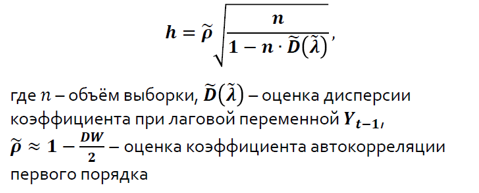
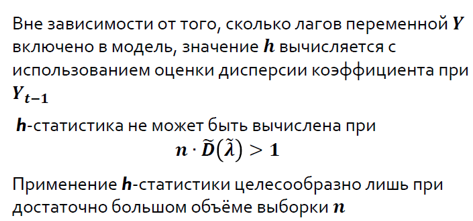

Вернусь к итоговой спецификации авторегрессионной модели

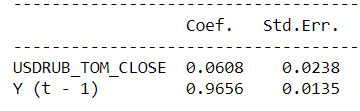

H0: автокорреляция возмущений в аторегрессионной модели отсутствует\
H1: автокорреляция возмущений в аторегрессионной модели присутствует

Проверю условие вычисления h-статистики

$ \tilde{D} (\tilde{\lambda}) $ - оценка дисперсии коэф-та при лаговой переменной.\
$ \tilde{D} (\tilde{\lambda}) = 0.00018 $\
n = 251

In [31]:
D_lambda = 0.0135**2
n = df.shape[0]

if D_lambda * n > 1:
    print('Условие вычисления h-статистики не выполнено')
    print(D_lambda * n)
else:
    print('Условие вычисления h-статистики выполнено')
    print(f'D_lambda * n = {round(D_lambda * n, 3)}')
    
    ro = X_avt['USDRUB_TOM_CLOSE'].corr(X_avt['Y (t - 1)'])
    h = ro * (n / (1 - n * D_lambda))**0.5
    h_cr = sts.norm.isf(0.05/2)
    print(f'h = {round(h, 3)}, h_cr = {round(h_cr, 3)}')
    
    print('_____________________________')
    if abs(h) > h_cr:
        print('H0 отклоняется')
    else:
        print('H0 не отклоняется')

Условие вычисления h-статистики выполнено
D_lambda * n = 0.046
h = 8.346, h_cr = 1.96
_____________________________
H0 отклоняется


**Вывод: исходя из h-теста, автокорреляция возмущений в авторегрессионной модели присутствует**

# 6. Построить модель адаптивных ожиданий

In [32]:
def adaptive_expectation(X, Y):
    print(f'Исходная спецификация: \nY_t = a + b*X`_(t-1) + E_t')
    
    model_adaptive = sm.OLS(Y[1:], X.iloc[1:,:1+2], hasconst = True).fit()
    params = np.array(model_adaptive.params).round(3)
    alpha = params[0]
    beta = params[1]
    mu = params[2]
    
    print('_____________________________')
    print(f'Полученная модель адаптивных ожиданий: \nYt = {alpha} + {beta}*X_t + {mu}*Y_(t-1) + u_t')
     
adaptive_expectation(X_avt, Y)

Исходная спецификация: 
Y_t = a + b*X`_(t-1) + E_t
_____________________________
Полученная модель адаптивных ожиданий: 
Yt = 1.627 + 0.053*X_t + 0.96*Y_(t-1) + u_t


# 7. Сделать частичную коректировку модели

In [33]:
def partial_adjustment(X, Y):
    print(f'Исходная спецификация: \nY`_t = a + b*X_t + E_t')
    
    model_partial = sm.OLS(Y[1:], X.iloc[1:,:1+2], hasconst = True).fit()
    params = np.array(model_partial.params).round(3)
    a = params[0]
    b = params[1]
    lambda_ = 1 - params[2]
    
    print('_____________________________')
    print(f'''Полученная модель после частичной корректировки: 
Yt =  {round((lambda_)*a, 3)} + {round(1-lambda_, 3)}*Y_(t-1) + {round(lambda_*b, 3)}*X_t + {round(lambda_, 3)}*E_t''')

partial_adjustment(X_avt, Y)

Исходная спецификация: 
Y`_t = a + b*X_t + E_t
_____________________________
Полученная модель после частичной корректировки: 
Yt =  0.065 + 0.96*Y_(t-1) + 0.002*X_t + 0.04*E_t


# 8. Лаги Алмон

In [43]:
def almon(X, y, k, N=2):
    # k - Кол-во лагов в модели
    # N - Степень многочлена
    X_Alm = pd.DataFrame()
    i = np.array([_ for _ in range(k, 0-1, -1)])
    
    for n in range(N+1):
        Z = []
        for offset in range(k+1, len(X) + 1):
            Z += [(np.array(X[offset - (k+1) : offset]).T * i**n).sum()]
        X_Alm.insert(loc=len(X_Alm.columns), column=f'Z_{n}', value=pd.Series(Z))
    
    X_Alm = sm.add_constant(X_Alm)
    model_almon = sm.OLS(y[k:].reset_index(drop=True), X_Alm).fit()
    
    print(model_almon.summary2(title='Полученная модель'))
    params = list(model_almon.params)
    equation = f'Y_t = {round(params[0], 3)}'
    for j in range(1, len(params)):
        equation += f' + {round(params[j], 3)}*Z_{j-1}'
    equation += ' + E_t'
    print('____________________________')
    print(f'''Уравнение модели:
{equation}''')

Модель метода Алмона с одним лагом и наивысшей степенью полинома равной двум

In [44]:
almon(X_avt['USDRUB_TOM_CLOSE'], Y, 1)

                        Полученная модель
Model:              OLS              Adj. R-squared:     0.279    
Dependent Variable: GMKN_CLOSE       AIC:                1728.0085
Date:               2024-04-23 11:00 BIC:                1738.5729
No. Observations:   250              Log-Likelihood:     -861.00  
Df Model:           2                F-statistic:        49.24    
Df Residuals:       247              Prob (F-statistic): 1.01e-18 
R-squared:          0.285            Scale:              58.104   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      79.8770     8.0918    9.8713   0.0000   63.9392   95.8147
Z_0        -0.2045     0.6301   -0.3245   0.7458   -1.4455    1.0365
Z_1         0.6438     0.6270    1.0267   0.3056   -0.5913    1.8788
Z_2         0.6438     0.6270    1.0267   0.3056   -0.5913    1.8788
------

Модель метода Алмона с двумя лагами и наивысшей степенью полинома равной двум

In [45]:
almon(X_avt['USDRUB_TOM_CLOSE'], Y, 2)

                        Полученная модель
Model:              OLS              Adj. R-squared:     0.286    
Dependent Variable: GMKN_CLOSE       AIC:                1720.8653
Date:               2024-04-23 11:00 BIC:                1734.9351
No. Observations:   249              Log-Likelihood:     -856.43  
Df Model:           3                F-statistic:        34.06    
Df Residuals:       245              Prob (F-statistic): 1.95e-18 
R-squared:          0.294            Scale:              57.818   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      78.4742     8.1280    9.6548   0.0000   62.4646   94.4839
Z_0        -0.0816     0.6323   -0.1290   0.8975   -1.3270    1.1638
Z_1        -0.3177     2.8236   -0.1125   0.9105   -5.8794    5.2440
Z_2         0.4184     1.3953    0.2999   0.7645   -2.3300    3.1668
------